In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils.load import add_noise, load_data
from utils.params import set_param

warnings.filterwarnings("ignore")

sns.set_theme(style="ticks")
np.random.seed(42)

In [3]:
exp = "p4581"
params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, Y, t, dt, vl = load_data(exp, dirs, params)
Y = Y[:, 0:2]

In [4]:
df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[
        "det_shear_stress",
        "obs_shear_stress",
        "obs_normal_stress",
        "time",
    ],
)
df.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.002811,1.29911,2.99288,0.000
1,0.002731,1.29903,2.99008,0.001
2,0.002231,1.29853,2.98854,0.002
3,0.002411,1.29871,2.98849,0.003
4,0.002241,1.29854,2.99069,0.004


In [5]:
df = df.rolling(window=int(1e3), step=int(1e3)).mean().dropna()
df = df.reset_index(drop=True)

In [6]:
df = df.dropna()
df.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.010441,1.306805,2.989703,0.500503
1,0.023812,1.320308,2.989567,1.500508
2,0.033829,1.330455,2.989649,2.500513
3,0.040971,1.337728,2.989704,3.500518
4,0.045985,1.342874,2.989764,4.500523


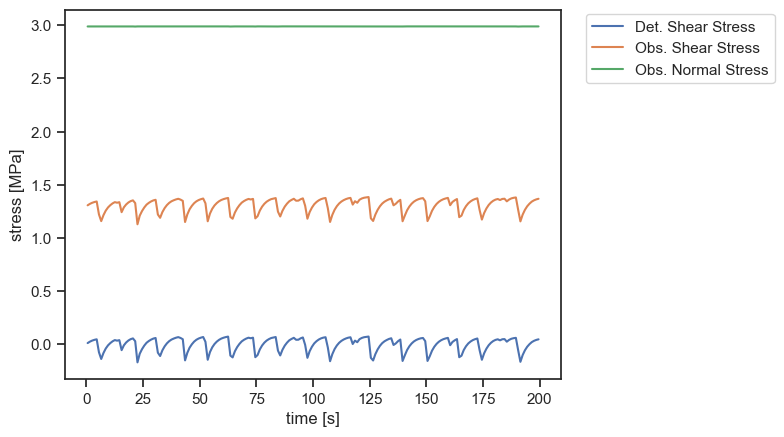

In [7]:
plt.plot(df["time"], df["det_shear_stress"], label="Det. Shear Stress")
plt.plot(df["time"], df["obs_shear_stress"], label="Obs. Shear Stress")
plt.plot(df["time"], df["obs_normal_stress"], label="Obs. Normal Stress")
plt.legend(loc=(1.05, 0.8))
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [8]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def perform_time_series_pca(series, n_lags, n_components):
    lagged_data = {f"lag_{i}": series.shift(i) for i in range(n_lags + 1)}
    lagged_df = pd.DataFrame(lagged_data)
    lagged_df.dropna(inplace=True)

    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(lagged_df)

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(standardized_data)

    pc_df = pd.DataFrame(
        data=principal_components,
        columns=[f"PC{i+1}" for i in range(n_components)],
    )

    return pc_df

In [9]:
from scipy.signal import argrelextrema


def find_local_minima(time_series):
    series_array = time_series.to_numpy()
    minima_indices = argrelextrema(series_array, np.less)[0]
    local_minima = time_series.iloc[minima_indices]
    return local_minima

In [10]:
pc_df = perform_time_series_pca(
    df["det_shear_stress"], n_lags=10, n_components=5
)

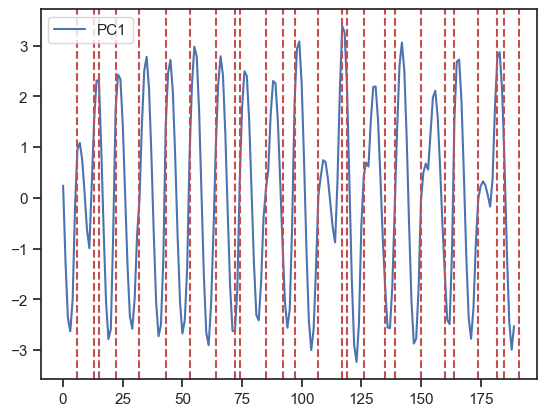

In [11]:
pc = "PC1"
pc_df[[pc]].plot()

for x in find_local_minima(df["det_shear_stress"]).index.values:
    plt.axvline(x=x, color="r", linestyle="--")

In [12]:
df = pc_df[[pc]]

In [13]:
RATIO = 0.70
LENGTH = df.shape[0]

train_data = df.iloc[: int(RATIO * LENGTH)]
test_data = df.iloc[int(RATIO * LENGTH) :]

In [14]:
import pmdarima as pm

model = pm.auto_arima(train_data[pc])

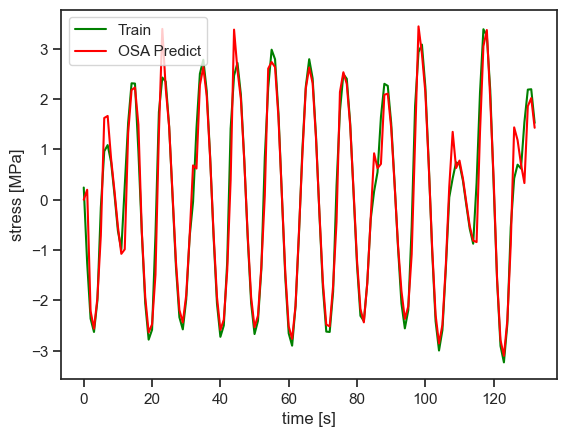

In [15]:
predict_train = model.fittedvalues()

plt.plot(train_data[pc], color="green")
plt.plot(predict_train, color="red")
plt.legend(["Train", "OSA Predict"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Train R^2 Score:  {r2_score(predict_train, train_data[pc]):.5f}")
print(
    f"Train RMSE Score: {np.sqrt(mean_squared_error(predict_train, train_data[pc])):.5f}"
)

Train R^2 Score:  0.95198
Train RMSE Score: 0.39661


In [17]:
import copy

from tqdm import tqdm


def perform_walkforward_validation(train_data, test_data, model):
    predictions = []
    for t in tqdm(range(len(test_data))):
        yhat = model.predict()[0] if t != 0 else model.predict().values[0]
        predictions.append(yhat)
        train_data = np.append(train_data, test_data[t : t + 1])
        model = model.fit(train_data)
    return predictions


test_model = copy.deepcopy(model)
predict_test = perform_walkforward_validation(
    train_data[pc].values,
    test_data[pc].values,
    test_model,
)

100%|██████████████████████████████████████████████████████| 57/57 [00:16<00:00,  3.50it/s]


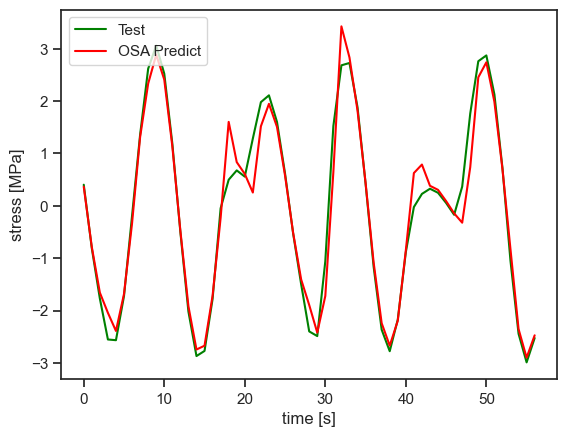

In [18]:
plt.plot(test_data[pc].values, color="green")
plt.plot(predict_test, color="red")
plt.legend(["Test", "OSA Predict"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Test R^2 Score:  {r2_score(predict_test, test_data[pc]):.5f}")
print(
    f"Test RMSE Score: {np.sqrt(mean_squared_error(predict_test, test_data[pc])):.5f}"
)

Test R^2 Score:  0.95513
Test RMSE Score: 0.36615


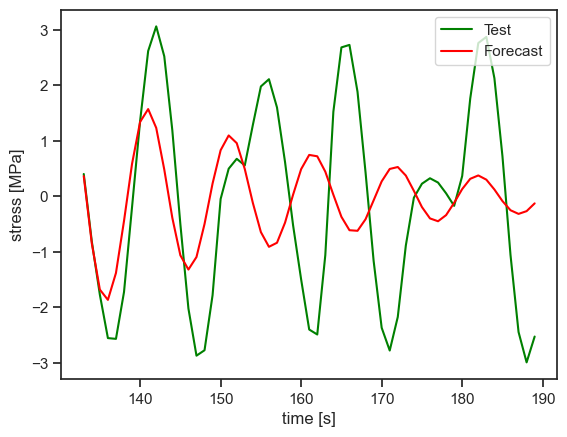

In [20]:
forecasts = model.predict(len(test_data))
forecasts = pd.Series(forecasts, index=test_data.index)

plt.plot(test_data[pc], color="green")
plt.plot(forecasts, color="red")
plt.legend(["Test", "Forecast"])
plt.xlabel("time [s]")
plt.ylabel("stress [MPa]")
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Forecast R^2 Score:  {r2_score(forecasts, test_data[pc]):.5f}")
print(
    f"Forecast RMSE Score: {np.sqrt(mean_squared_error(forecasts, test_data[pc])):.5f}"
)

Forecast R^2 Score:  -4.99547
Forecast RMSE Score: 1.76525


In [22]:
model

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)